In [1]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [84]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rotation_range=15,        # Slight rotation (Bell's Palsy is sensitive to asymmetry)
    width_shift_range=0.1,   # Small horizontal shifts
    height_shift_range=0.1,  # Small vertical shifts
    shear_range=0.1,         # Mild shear distortions
    zoom_range=0.1,          # Slight zoom
    horizontal_flip=True,    # Critical for facial symmetry tasks
    fill_mode='nearest',     # Fill missing pixels
    rescale=1./255           # Normalize pixel values
)

In [3]:
# Validation/Test Data (No Augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Dataset Paths
train_dir = "/content/drive/MyDrive/Dataset/train"
val_dir = "/content/drive/MyDrive/Dataset/val"
test_dir = "/content/drive/MyDrive/Dataset/test"

In [4]:
train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_set = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_set = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # For correct confusion matrix
)

Found 920 images belonging to 4 classes.
Found 112 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


In [5]:
# Class Weighting (if imbalanced)
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_set.classes),
    y=train_set.classes
)
class_weights = dict(enumerate(class_weights))

In [6]:
# Replace the entire build_model function with:
def build_model(learning_rate=1e-4):
    base_model = ResNet50(   # Changed to ResNet50
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    )

    base_model.trainable = False  # Freeze pretrained layers initially

    x = base_model.output
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)

    predictions = Dense(len(train_set.class_indices), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [7]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.55,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [ ]:
# Train with 3 Learning Rates (Test Which Works Best)
learning_rates = [1e-4, 3e-5, 1e-5]  # Empirically strong choices

for lr in learning_rates:
    print(f"\nTraining with LR = {lr}")
    model = build_model(learning_rate=lr)
    history = model.fit(
        train_set,
        validation_data=val_set,
        epochs=30,
        class_weight=class_weights,
        callbacks=[early_stopping, reduce_lr]
    )


Training with LR = 0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.3703 - loss: 1.3309 - val_accuracy: 0.4286 - val_loss: 1.3184 - learning_rate: 1.0000e-04
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 718ms/step - accuracy: 0.5757 - loss: 1.1222 - val_accuracy: 0.4732 - val_loss: 1.2030 - learning_rate: 1.0000e-04
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 23s 811ms/step - accuracy: 0.6377 - loss: 0.9775 - val_accuracy: 0.5357 - val_loss: 1.1174 - learning_rate: 1.0000e-04
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 720ms/step - accuracy: 0.6747 - loss: 0.8864 - val_accuracy: 0.7143 - val_loss: 0.9975 - learning_rate: 1.0000e-04
Epoch 5/30
 1/29 ━━━━━━━━━━━━━━━━━━━━ 27s 978ms/step - accuracy: 0.6875 - loss: 0.8811

In [51]:
    model.save(f"bellspalsy_modelr_{lr}.h5")

In [52]:
test_loss, test_acc = model.evaluate(test_set)
print(f"Test Accuracy (LR={1e-4}): {test_acc:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8433 - loss: 0.7265
Test Accuracy (LR=0.0001): 0.8167


In [53]:
from tensorflow.keras.models import load_model # Import the load_model function

best_model = load_model(f"bellspalsy_modelr_{lr}.h5")  # Replace with best LR

for layer in best_model.layers[-20:]:
    layer.trainable = True

best_model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune = best_model.fit(
    train_set,
    validation_data=val_set,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5069 - loss: 1.0866 - val_accuracy: 0.8393 - val_loss: 0.7003
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 722ms/step - accuracy: 0.5758 - loss: 1.0135 - val_accuracy: 0.9018 - val_loss: 0.6025
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 22s 773ms/step - accuracy: 0.6436 - loss: 0.8806 - val_accuracy: 0.9107 - val_loss: 0.5156
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 22s 773ms/step - accuracy: 0.6847 - loss: 0.8320 - val_accuracy: 0.9375 - val_loss: 0.4505
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 723ms/step - accuracy: 0.6811 - loss: 0.7882 - val_accuracy: 0.9643 - val_loss: 0.3970
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 26s 889ms/step - accuracy: 0.7441 - loss: 0.7152 - val_accuracy: 0.9643 - val_loss: 0.3512
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 23s 789ms/step - accuracy: 0.7551 - loss: 0.6755 - val_accuracy: 0.9732 - val_loss: 0.3197
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 730ms/step - accuracy: 0.7977 - loss: 0.5997 - val_accurac

In [54]:
y_pred = best_model.predict(test_set)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_set.classes
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1       0.97      0.97      0.97        30
           2       1.00      0.97      0.98        30
           3       1.00      1.00      1.00        30

    accuracy                           0.98       120
   macro avg       0.98      0.98      0.98       120
weighted avg       0.98      0.98      0.98       120



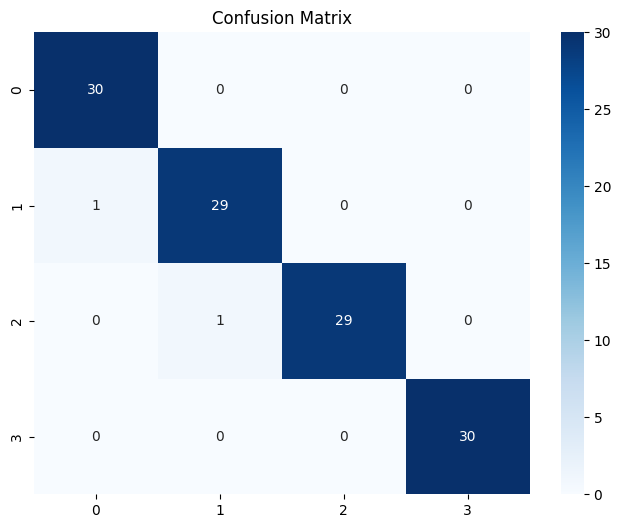

In [55]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step


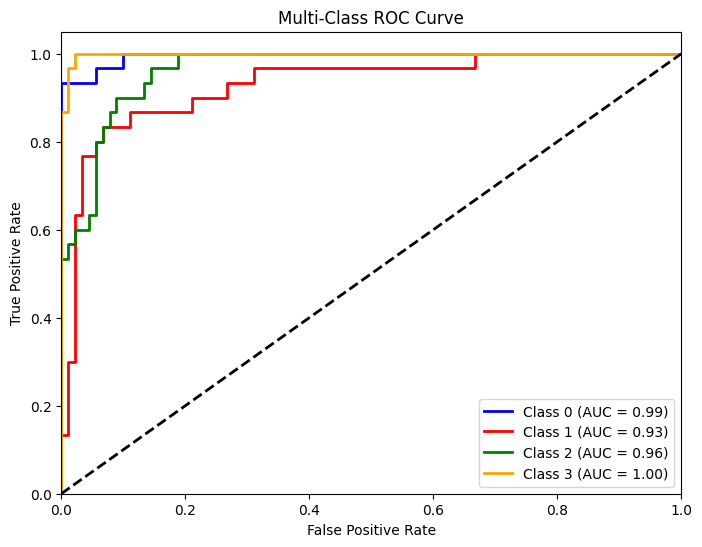

In [56]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# 1. Binarize the true labels (for multi-class ROC)
y_true = test_set.classes
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
n_classes = y_true_bin.shape[1]

# 2. Get predicted probabilities
y_pred_prob = model.predict(test_set)

# 3. Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 4. Plot ROC curves
plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green', 'orange'])  # Adjust colors to match # of classes

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.show()

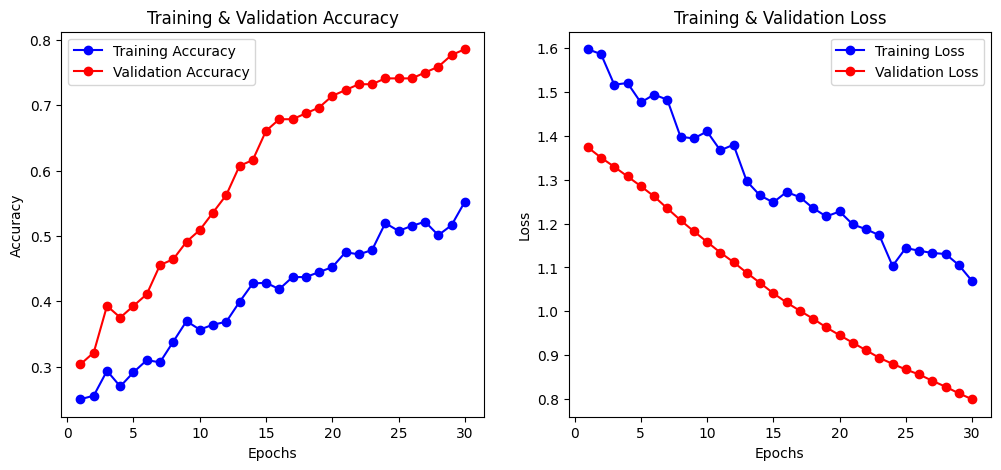

In [57]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_history(history):
    # Extract training history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)  # Get number of epochs

    # Plot Accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()

    plt.show()

# Call the function with model history
plot_history(history)

In [58]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')  # Weighted for imbalanced classes
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9833
Precision: 0.9836
Recall: 0.9833
F1 Score: 0.9833


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 343ms/step


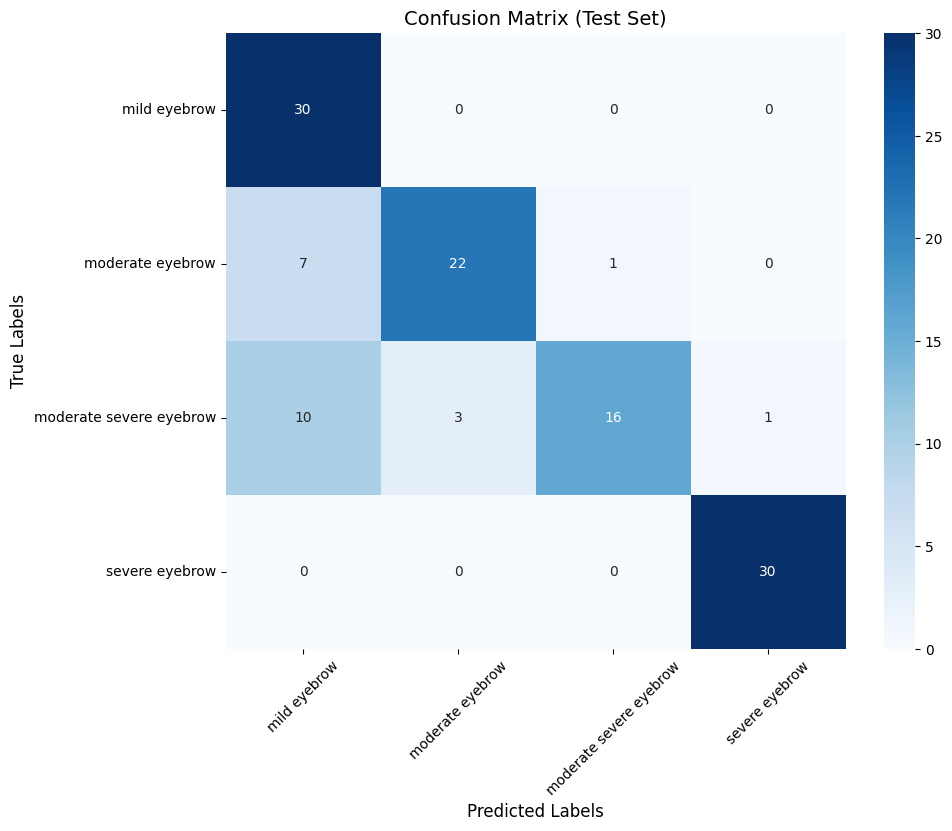


Classification Report:
                         precision    recall  f1-score   support

           mild eyebrow       0.64      1.00      0.78        30
       moderate eyebrow       0.88      0.73      0.80        30
moderate severe eyebrow       0.94      0.53      0.68        30
         severe eyebrow       0.97      1.00      0.98        30

               accuracy                           0.82       120
              macro avg       0.86      0.82      0.81       120
           weighted avg       0.86      0.82      0.81       120



In [60]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Get true labels and predictions
y_true = test_set.classes
y_pred = model.predict(test_set)
y_pred_classes = np.argmax(y_pred, axis=1)

# 2. Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# 3. Plot with annotations and improved visuals
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_set.class_indices.keys(),
            yticklabels=test_set.class_indices.keys())
plt.title('Confusion Matrix (Test Set)', fontsize=14)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# 4. Print classification metrics
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes,
                          target_names=test_set.class_indices.keys()))

In [61]:
from sklearn.metrics import roc_auc_score
y_prob = model.predict(test_set)
for i, class_name in enumerate(test_set.class_indices.keys()):
    auc = roc_auc_score((y_true == i).astype(int), y_prob[:, i])
    print(f"{class_name} AUC: {auc:.3f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step
mild eyebrow AUC: 0.995
moderate eyebrow AUC: 0.930
moderate severe eyebrow AUC: 0.965
severe eyebrow AUC: 0.998


In [62]:
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_true, y_pred_classes)
print(f"MCC: {mcc:.3f}")

MCC: 0.773


In [63]:
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y_true, y_pred_classes)
print(f"Cohen's Kappa: {kappa:.3f}")

Cohen's Kappa: 0.756


In [64]:
from sklearn.metrics import hamming_loss
h_loss = hamming_loss(y_true, y_pred_classes)
print(f"Hamming Loss: {h_loss:.3f}")

Hamming Loss: 0.183


In [65]:
from sklearn.metrics import balanced_accuracy_score
bal_acc = balanced_accuracy_score(y_true, y_pred_classes)
print(f"Balanced Accuracy: {bal_acc:.3f}")

Balanced Accuracy: 0.817


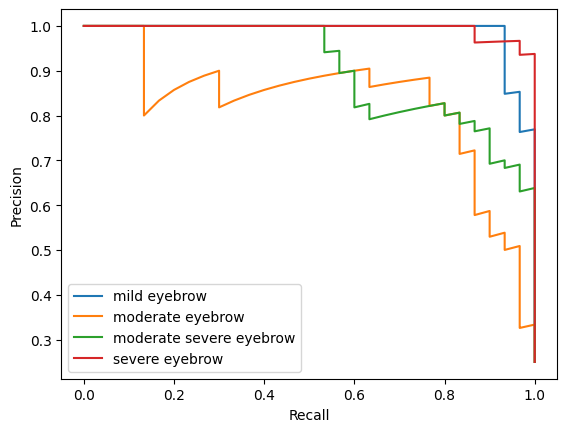

In [66]:
from sklearn.metrics import precision_recall_curve
for i, class_name in enumerate(test_set.class_indices.keys()):
    precision, recall, _ = precision_recall_curve((y_true == i), y_prob[:, i])
    plt.plot(recall, precision, label=class_name)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

In [67]:
from sklearn.metrics import jaccard_score
for i in range(len(test_set.class_indices)):
    print(f"Class {i} IoU: {jaccard_score(y_true == i, y_pred_classes == i):.3f}")

Class 0 IoU: 0.638
Class 1 IoU: 0.667
Class 2 IoU: 0.516
Class 3 IoU: 0.968


In [68]:
top2_acc = np.mean([1 if y_true[i] in np.argsort(y_prob[i])[-2:] else 0
                   for i in range(len(y_true))])
print(f"Top-2 Accuracy: {top2_acc:.3f}")

Top-2 Accuracy: 0.975


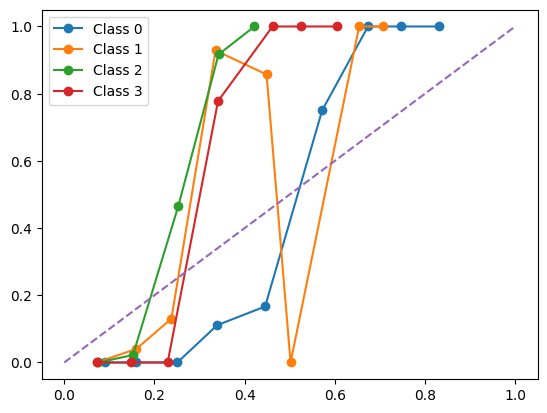

In [69]:
from sklearn.calibration import calibration_curve
for i in range(len(test_set.class_indices)):
    prob_true, prob_pred = calibration_curve((y_true == i), y_prob[:, i], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=f'Class {i}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend()

In [70]:
mae = np.mean(np.abs(y_true - y_pred_classes))
print(f"MAE: {mae:.2f} severity grades")

MAE: 0.27 severity grades


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


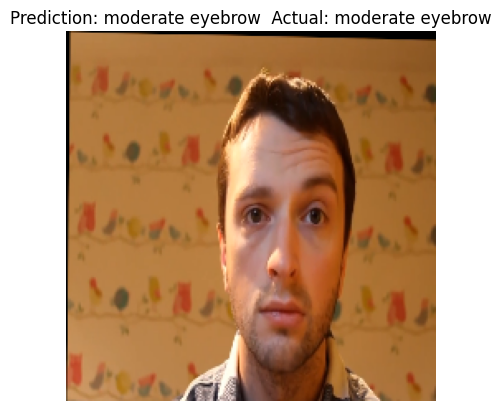

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


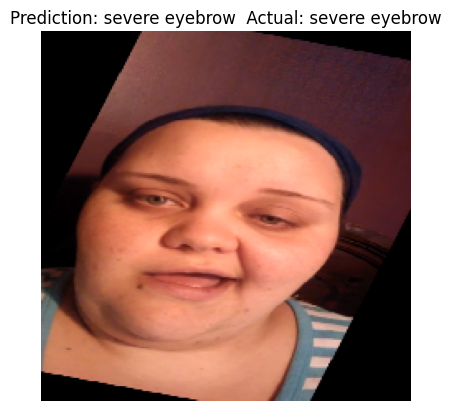

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


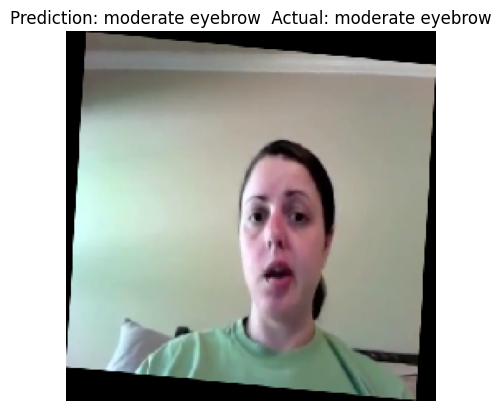

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


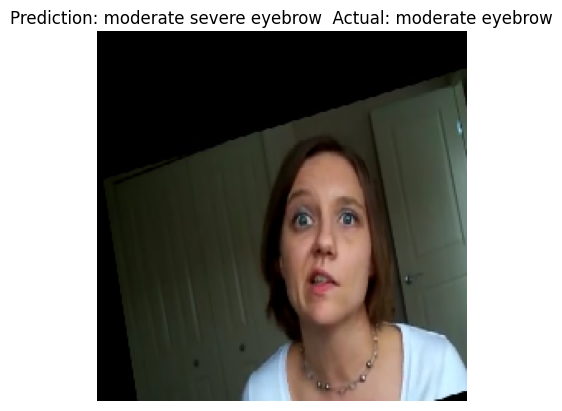

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


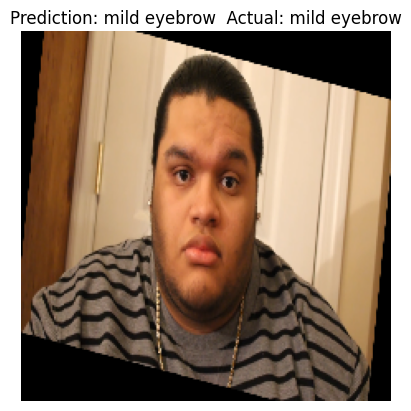

In [72]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
import random
import os

# Load your trained model
best_model = load_model(f"bellspalsy_modelr_{lr}.h5")  # Replace with your actual model file

def predict_and_display(image_path, model, class_labels):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    predicted_class_label = class_labels[predicted_class_index]

    plt.imshow(img)
    plt.axis('off')

    # Get the actual label from the image path
    actual_class_label = os.path.basename(os.path.dirname(image_path))

    plt.title(f"Prediction: {predicted_class_label}  Actual: {actual_class_label}")
    plt.show()

# Define your class labels
class_labels = ['mild eyebrow', 'moderate eyebrow', 'moderate severe eyebrow', 'severe eyebrow']

# Path to your test dataset directory
test_dir = "/content/drive/My Drive/Dataset/test"  # Replace with your test directory path

# Get a list of all image file paths in the test directory
image_files = []
for class_name in os.listdir(test_dir):
    class_dir = os.path.join(test_dir, class_name)
    if os.path.isdir(class_dir):
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):  # Add other extensions if needed
                image_files.append(os.path.join(class_dir, filename))

# Pick 5 random image files
random_image_paths = random.sample(image_files, 5)

# Make the predictions and display
for image_path in random_image_paths:
    predict_and_display(image_path, best_model, class_labels)